In [29]:
## imports
import os  # For interacting with the operating system

import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation library
import seaborn as sns  # Statistical data visualization library
import matplotlib.pyplot as plt  # Plotting library

from sklearn.pipeline import make_pipeline  # Constructing pipelines
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler  # Data preprocessing techniques
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier  # Ensemble learning models
from sklearn.metrics import accuracy_score  # Evaluation metrics
from sklearn.pipeline import Pipeline  # Constructing pipelines
from sklearn.feature_selection import RFE  # Recursive feature elimination
from sklearn.linear_model import LogisticRegression  # Logistic regression model
from sklearn.model_selection import train_test_split  # Data splitting

from tpot import TPOTClassifier  # Automated machine learning tool
from tpot.builtins import ZeroCount  # Preprocessing for zero count features
from tpot.export_utils import set_param_recursive  # Utility for setting parameters recursively

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE  # Oversampling techniques

print("Current working directory:", os.getcwd())  # Printing current working directory

## global variables
DATA_PATH = "../../data/raw/teco-psda-exercisesheet1-hdma-2024"  # Path to the data directory
SCALE_PRIOR = False  # Flag indicating whether to scale features prior to modeling


Current working directory: /Users/frbroy/Library/Mobile Documents/com~apple~CloudDocs/KIT/SoSe2024/PSDA/prac-smart-data-analytics/notebooks/exercise-01


## Load the data

In [30]:
# Load the train dataset
train_df = pd.read_csv(DATA_PATH + "/hdma_train.csv")

# Load the test dataset
test_df = pd.read_csv(DATA_PATH + "/hdma_test.csv")

# Load the test dataset
test_sample_df = pd.read_csv(DATA_PATH + "/hdma_test_sample.csv")

In [31]:
train_df.head()

,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
0,0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,False
1,1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,False
2,2,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,False
3,3,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,False
4,4,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,False


## Data exploration

In [32]:
## data exploration
print("Number of records and features:", train_df.shape)

# 2. Display First Few Records
print("First few records:")
print(train_df.head())

# 3. Data Types of Features
print("Data types of features:")
print(train_df.dtypes)

# 4. Statistical Summary
print("Statistical summary:")
print(train_df.describe())
## --> mean and std looks good for variables

# 5. Distribution of Target Variables
# Assuming if there is a column named "target"
if "target" in train_df.columns:
    print("Distribution of target variables:")
    print(train_df["target"].value_counts())

# 6. Missing Values
print("Number of missing values per feature:")
print(train_df.isnull().sum())
## --> no missing values: good

Number of records and features: (2281, 14)
First few records:
   Unnamed: 0    dir    hir       lvr  ccs  mcs pbcr dmi self single  uria  \
0           0  0.221  0.221  0.800000  5.0  2.0   no  no   no     no   3.9   
1           1  0.265  0.265  0.921875  2.0  2.0   no  no   no    yes   3.2   
2           2  0.372  0.248  0.920398  1.0  2.0   no  no   no     no   3.2   
3           3  0.320  0.250  0.860465  1.0  2.0   no  no   no     no   4.3   
4           4  0.360  0.350  0.600000  1.0  1.0   no  no   no     no   3.2   

   condo black   deny  
0      0    no  False  
1      0    no  False  
2      0    no  False  
3      0    no  False  
4      0    no  False  
Data types of features:
Unnamed: 0      int64
dir           float64
hir           float64
lvr           float64
ccs           float64
mcs           float64
pbcr           object
dmi            object
self           object
single         object
uria          float64
condo           int64
black          object
deny           

## Data preprocessing

In [33]:
## data preprocessing

# Perform one-hot encoding using pandas
train_df['condo'] = train_df['condo'].astype(str)
test_df["condo"] = train_df["condo"].astype(str)
categorical_cols = ["pbcr", "dmi", "self", "single", "condo", "black"]

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([ train_df.drop(columns=categorical_cols) , pd.get_dummies(train_df[categorical_cols]).astype(int)], axis=1)
df_encoded_test = pd.concat([ test_df.drop(columns=categorical_cols) , pd.get_dummies(test_df[categorical_cols]).astype(int)], axis=1)

# drop unwanted "Unnamed: 0"
train_df_enc = df_encoded.drop(columns=["Unnamed: 0"])
test_df_enc = df_encoded_test.drop(columns=["Unnamed: 0"])

# check correctness
display(train_df_enc.head())

,dir,hir,lvr,ccs,mcs,uria,deny,pbcr_no,pbcr_yes,dmi_no,dmi_yes,self_no,self_yes,single_no,single_yes,condo_0,condo_1,black_no,black_yes
0,0.221,0.221,0.800000,5.0,2.0,3.9,False,1,0,1,0,1,0,1,0,1,0,1,0
1,0.265,0.265,0.921875,2.0,2.0,3.2,False,1,0,1,0,1,0,0,1,1,0,1,0
2,0.372,0.248,0.920398,1.0,2.0,3.2,False,1,0,1,0,1,0,1,0,1,0,1,0
3,0.320,0.250,0.860465,1.0,2.0,4.3,False,1,0,1,0,1,0,1,0,1,0,1,0
4,0.360,0.350,0.600000,1.0,1.0,3.2,False,1,0,1,0,1,0,1,0,1,0,1,0


In [35]:
# Feature Scaling
if SCALE_PRIOR:
    scaler = StandardScaler()
    columns_to_scale = ['dir', 'hir', 'lvr', 'ccs', 'mcs', 'uria']

    train_df_enc[columns_to_scale] = scaler.fit_transform(train_df_enc[columns_to_scale])
    test_df_enc[columns_to_scale] = scaler.fit_transform(test_df_enc[columns_to_scale])

    # Print the scaled DataFrame
    display(test_df_enc.head())

## Data visualization

/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

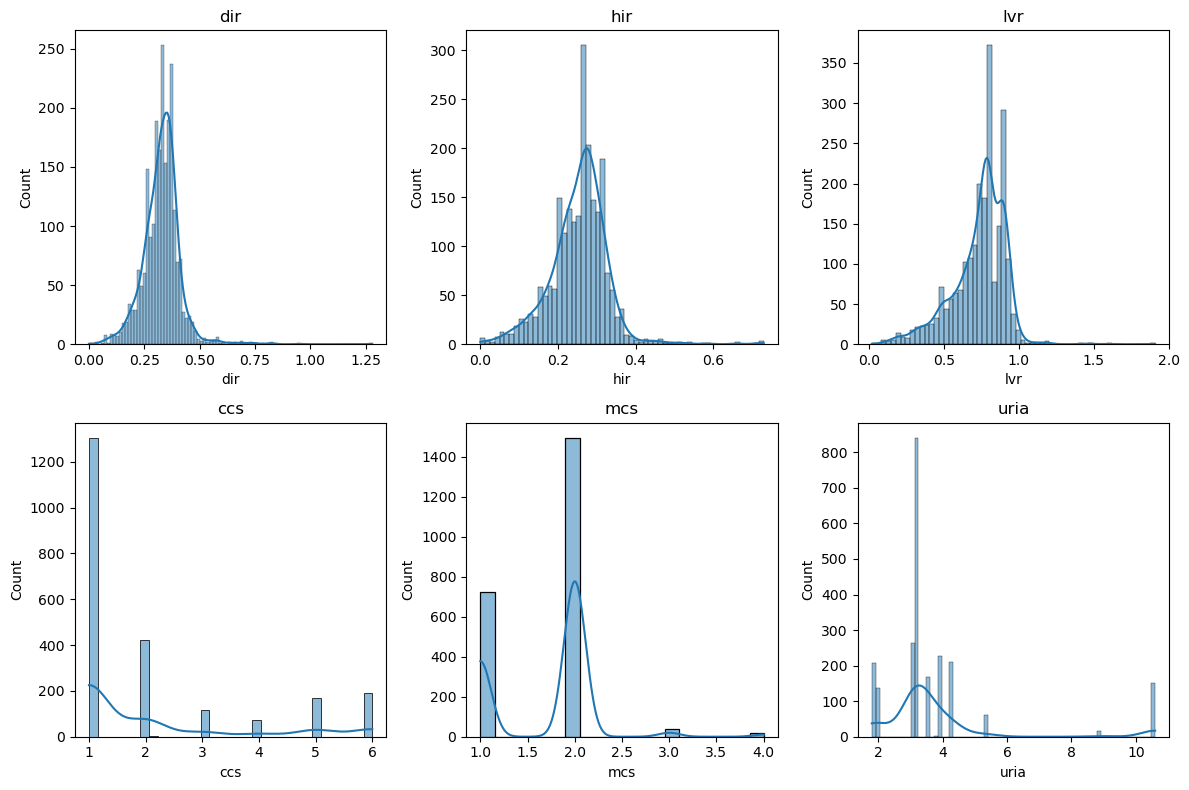

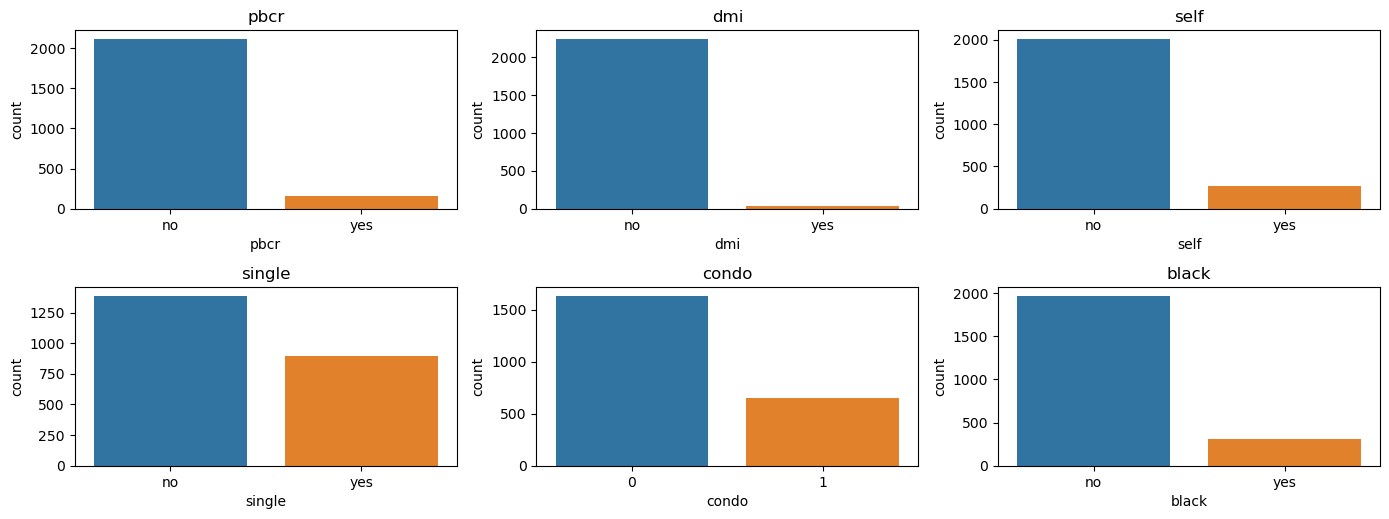

In [37]:
# Data Visualization
# Plot histograms for continuous variables
continuous_cols = ['dir', 'hir', 'lvr', 'ccs', 'mcs', 'uria']
plt.figure(figsize=(12, 8))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Plot count plots for categorical variables
categorical_cols = [ 'pbcr', 'dmi', 'self',
       'single','condo', 'black']
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=train_df, x=col)
    plt.title(col)
plt.tight_layout()
plt.show()


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: Fu

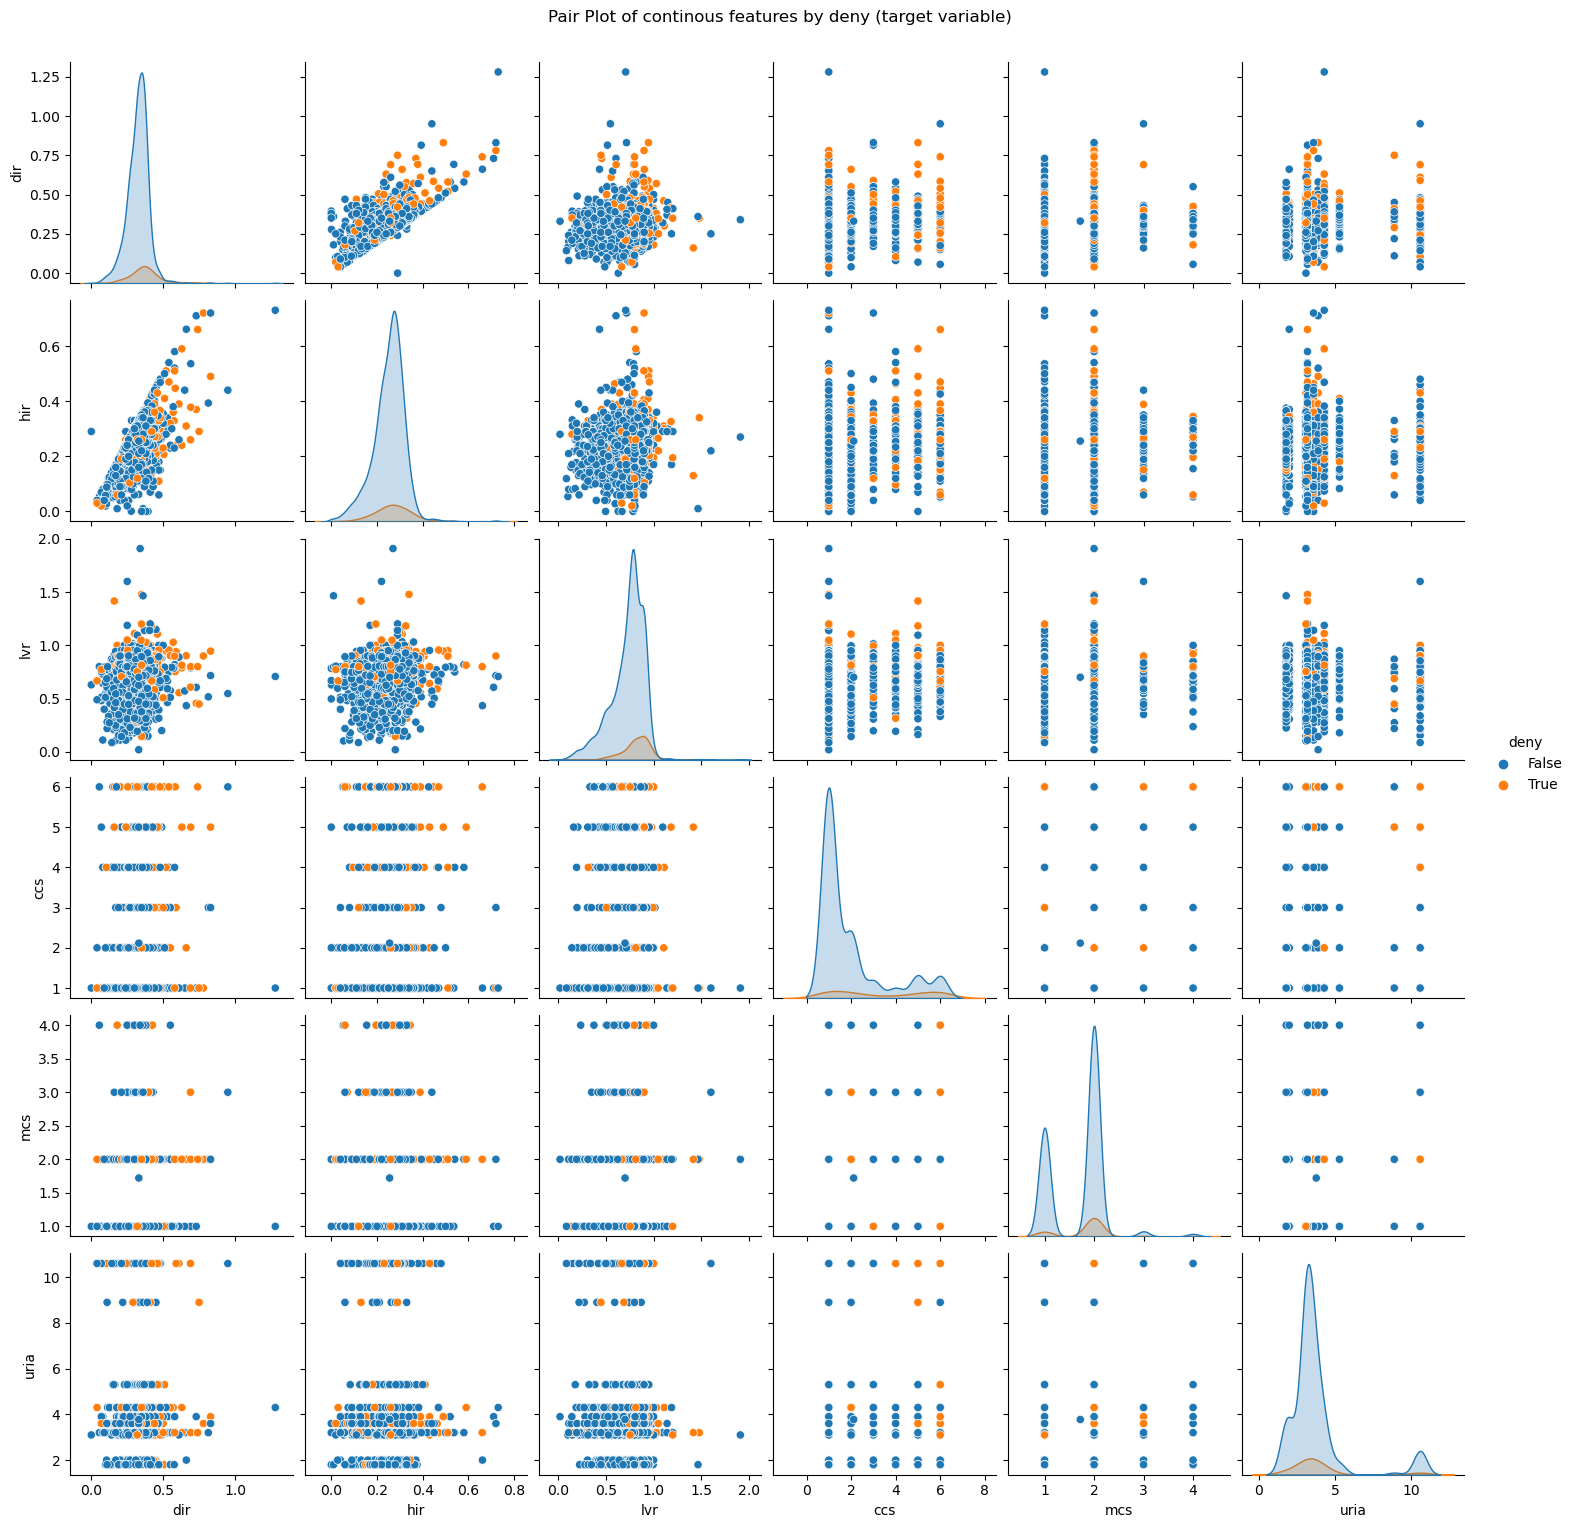

In [38]:
sns.pairplot(train_df.loc[:, ['dir', 'hir', 'lvr', 'ccs', 'mcs', 'uria', "deny"]], hue='deny')
plt.suptitle('Pair Plot of continous features by deny (target variable)', y=1.02)
plt.show()

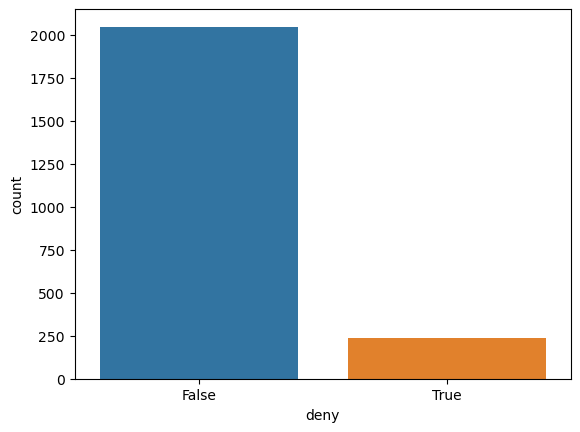

In [39]:
sns.countplot(data=train_df_enc, x="deny")
plt.show()

## Feature Selection

In [40]:
# Feature Selection

## Based on correlarion
correlation_matrix = train_df_enc.corr()

# Select features with a certain correlation threshold
correlation_threshold = 0.05
selected_features = correlation_matrix[abs(correlation_matrix['deny']) > correlation_threshold].index

filtered_data = train_df_enc[selected_features]
print(f"Now we have {len(filtered_data.columns)-1}/{len(train_df_enc.columns)-1} features: {filtered_data.columns}")

Now we have 15/18 features: Index(['dir', 'hir', 'lvr', 'ccs', 'mcs', 'deny', 'pbcr_no', 'pbcr_yes',
       'dmi_no', 'dmi_yes', 'self_no', 'self_yes', 'single_no', 'single_yes',
       'black_no', 'black_yes'],
      dtype='object')


In [41]:
## Rekursiv Feature Selection:
X = train_df_enc.drop(columns=['deny'])
y = train_df_enc["deny"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

acc = 0
model = LogisticRegression()


for num_features_to_select in range(3, len(X_train.columns)):
    rfe = RFE(model, n_features_to_select=num_features_to_select)

    X_train_new = rfe.fit_transform(X_train, y_train)
    X_test_new = X_test.iloc[:, rfe.support_] 

    # Train and evaluate a model using the selected features
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Number of Features: {num_features_to_select}, Accuracy: {accuracy:.4f}")
    
    ## store 15 best features for Adasyn
    if num_features_to_select == 15:
       store_15 = rfe.support_
       print(f"best 15 for Oversampling: {store_15}")
    if accuracy > acc:
      acc = accuracy
      x_store = rfe.support_

/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Number of Features: 3, Accuracy: 0.9037


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 4, Accuracy: 0.9037


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 5, Accuracy: 0.9059


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 6, Accuracy: 0.9103


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 7, Accuracy: 0.9103


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 8, Accuracy: 0.9103


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 9, Accuracy: 0.9081


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 10, Accuracy: 0.9103


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Number of Features: 11, Accuracy: 0.9103


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Number of Features: 12, Accuracy: 0.9103
Number of Features: 13, Accuracy: 0.9103


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Number of Features: 14, Accuracy: 0.9103
Number of Features: 15, Accuracy: 0.9103
best 15 for Oversampling: [ True  True  True  True  True False  True  True  True  True  True  True
  True  True False False  True  True]


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

Number of Features: 16, Accuracy: 0.9125
Number of Features: 17, Accuracy: 0.9147


/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/frbroy/miniconda3/envs/psda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [42]:
# Select only good features after feature selection:
X_RFE = X.iloc[:, store_15]
display(X_RFE.head())

,dir,hir,lvr,ccs,mcs,pbcr_no,pbcr_yes,dmi_no,dmi_yes,self_no,self_yes,single_no,single_yes,black_no,black_yes
0,0.221,0.221,0.800000,5.0,2.0,1,0,1,0,1,0,1,0,1,0
1,0.265,0.265,0.921875,2.0,2.0,1,0,1,0,1,0,0,1,1,0
2,0.372,0.248,0.920398,1.0,2.0,1,0,1,0,1,0,1,0,1,0
3,0.320,0.250,0.860465,1.0,2.0,1,0,1,0,1,0,1,0,1,0
4,0.360,0.350,0.600000,1.0,1.0,1,0,1,0,1,0,1,0,1,0


## Classifier 

In [47]:
## Resampling Strategy

X = train_df_enc.drop('deny', axis=1).loc[:, store_15]
y = train_df_enc['deny']                # Zielvariable ist in der Spalte 'target'

# Teilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.185, random_state=42)


hyp_sampling = [0.17, 0.19, 0.2, 0.27]
best = 0
for i in hyp_sampling:

    # Apply ADASYN
    adasyn = SMOTE(sampling_strategy=i, random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

    pipeline_optimizer = TPOTClassifier(generations=10, population_size=25, cv=10,
                                        random_state=42, verbosity=2)
    pipeline_optimizer.fit(X_resampled, y_resampled)
    acc = pipeline_optimizer.score(X_test, y_test)
    print(f"Adasyn {i} has Acc: {acc}")
    if acc > best:
        best = acc
        mdl = pipeline_optimizer
        ada = i
        print(f"Adasyn {ada} is the best with {acc}")

mdl.export(f'tpot_pipeline_adasyn_{int(ada*100)}_{int(best*1000)}.py')


                                                                             
Generation 1 - Current best internal CV score: 0.8932778218345229
                                                                             
Generation 2 - Current best internal CV score: 0.8932778218345229
                                                                             
Generation 3 - Current best internal CV score: 0.8932778218345229
                                                                              
Generation 4 - Current best internal CV score: 0.8932778218345229
                                                                              
Generation 5 - Current best internal CV score: 0.8932778218345229
                                                                              
Generation 6 - Current best internal CV score: 0.9009965635738831
                                                                              
Generation 7 - Current best internal CV score: 0.90099

In [13]:
## No Resampling Method!! --> yielded better results

X = train_df_enc.drop('deny', axis=1) # Features are all columns except the target variable
y = train_df_enc['deny'] # Target variable is in the column 'deny'               

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.185, random_state=42)

# Initializing TPOTClassifier for automated model optimization
pipeline_optimizer = TPOTClassifier(generations=15, population_size=30, cv=10,
                                    random_state=42, verbosity=2)

# Fitting the TPOTClassifier to find the best model
pipeline_optimizer.fit(X_train, y_train)

# Evaluating the best model on the test set
acc = pipeline_optimizer.score(X_test, y_test)

# Printing the accuracy of the best model
print(f"Best model without resampling has Acc: {acc}")


                                                                             
Generation 1 - Current best internal CV score: 0.9117756466143563
                                                                             
Generation 2 - Current best internal CV score: 0.9117756466143563
                                                                              
Generation 3 - Current best internal CV score: 0.9123161871548968
                                                                              
Generation 4 - Current best internal CV score: 0.9123161871548968
                                                                              
Generation 5 - Current best internal CV score: 0.9133885498401627
                                                                              
Generation 6 - Current best internal CV score: 0.913391455972101
                                                                              
Generation 7 - Current best internal CV score: 0.91339

NameError: name 'best' is not defined

## Load best oversampling model

In [47]:
# Creating an instance of the ADASYN (Adaptive Synthetic Sampling) oversampling technique
# with a specified sampling strategy and random state
adasyn = ADASYN(sampling_strategy=0.19, random_state=42)

# Resampling the dataset using ADASYN to address class imbalance
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Constructing a pipeline consisting of data scaling and a random forest classifier
exported_pipeline = make_pipeline(
    MinMaxScaler(),  # Scaling features to a specified range
    RandomForestClassifier(  # Random forest classifier with specified hyperparameters
        bootstrap=True,
        criterion="gini",
        max_features=0.5,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=100
    )
)

# Fitting the pipeline to the resampled data
exported_pipeline.fit(X_resampled, y_resampled)

# Evaluating the pipeline on the test set and calculating accuracy
acc = exported_pipeline.score(X_test, y_test)


## Prediction on test set

In [45]:
predictions = exported_pipeline.predict(test_df_enc)
test_sample_df["Expected"] = predictions

## Best model

In [48]:
# Constructing a pipeline for preprocessing and modeling:
exported_pipeline = make_pipeline(
    RobustScaler(),  # Scaling features using statistics robust to outliers.
    ZeroCount(),  # Preprocessing step for zero count features in TPOT.
    MinMaxScaler(),  # Scaling features to a specified range.
    RandomForestClassifier(  # Random forest classifier with specific hyperparameters.
        bootstrap=True,
        criterion="gini",
        max_features=0.2,
        min_samples_leaf=2,
        min_samples_split=4,
        n_estimators=100
    )
)

# Fixing the random state for all the steps in the exported pipeline:
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

# Fitting the pipeline to the entire dataset:
exported_pipeline.fit(X, y)


Pipeline(steps=[('robustscaler', RobustScaler()), ('zerocount', ZeroCount()),
                ('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=0.2, min_samples_leaf=2,
                                        min_samples_split=4,
                                        random_state=42))])

## Best Model Prediction

In [21]:
predictions = exported_pipeline.predict(test_df_enc)
test_sample_df["Expected"] = predictions
test_sample_df.to_csv(DATA_PATH + "/best_model_pred_replicat.csv", index = False)